# Google Play Store Data

We will predit the rating of a Google Play Store app as a function of its attributes. We get our data from this source: https://www.kaggle.com/lava18/google-play-store-apps

Our first step will be to import all of the modules we need, and then load the data.

In [242]:
import Pkg
Pkg.add("CSV")
# Pkg.add("Plots")
Pkg.add("DataFrames")
Pkg.add("Statistics")
Pkg.add("StatsPlots")
Pkg.add("Measures")
Pkg.add("LowRankModels")
include("proxgrad.jl")
Pkg.add("Dates")

using Random
Random.seed!(13)

using CSV
# using Plots
using DataFrames
using StatsPlots
using Statistics
using LinearAlgebra
using Measures
using LowRankModels
using Dates

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/

In [339]:
apps = CSV.read("googleplaystore.csv", pool=false)
names!(apps, Symbol.(replace.(string.(names(apps)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(apps)
for i in 1:13
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
thread = 1 warning: only found 12 / 13 columns around data row: 10474. Filling remaining columns with `missing`
1	App			String
2	Category			String
3	Rating			Float64
4	Reviews			String
5	Size			String
6	Installs			String
7	Type			String
8	Price			String
9	ContentRating			Union{Missing, String}
10	Genres			String
11	LastUpdated			String
12	CurrentVer			Union{Missing, String}
13	AndroidVer			Union{Missing, String}


In [340]:
apps

10841×13 DataFrame. Omitted printing of 12 columns
│ Row   │ App                                                │
│       │ String                                             │
├───────┼────────────────────────────────────────────────────┤
│ 1     │ Photo Editor & Candy Camera & Grid & ScrapBook     │
│ 2     │ Coloring book moana                                │
│ 3     │ U Launcher Lite – FREE Live Cool Themes, Hide Apps │
│ 4     │ Sketch - Draw & Paint                              │
│ 5     │ Pixel Draw - Number Art Coloring Book              │
│ 6     │ Paper flowers instructions                         │
│ 7     │ Smoke Effect Photo Maker - Smoke Editor            │
│ 8     │ Infinite Painter                                   │
│ 9     │ Garden Coloring Book                               │
│ 10    │ Kids Paint Free - Drawing Fun                      │
⋮
│ 10831 │ News Minecraft.fr                                  │
│ 10832 │ payermonstationnement.fr                           │
│ 10833 │ FR Tides                                           │
│ 10834 │ Chemin (fr)                                        │
│ 10835 │ FR Calculator                                      │
│ 10836 │ FR Forms                                           │
│ 10837 │ Sya9a Maroc - FR                                   │
│ 10838 │ Fr. Mike Schmitz Audio Teachings                   │
│ 10839 │ Parkinson Exercices FR                             │
│ 10840 │ The SCP Foundation DB fr nn5n                      │
│ 10841 │ iHoroscope - 2018 Daily Horoscope & Astrology      │

# (A) Clean Data

In [341]:
#Clean Ratings column 

new_ratings = Float64[]
for idx=1:size(apps,1)
    if !isnan(apps[idx, :Rating])
        push!(new_ratings, apps[idx, :Rating])
    end
end 
        
for idx=1:size(apps,1)
    if isnan(apps[idx, :Rating])
        apps[idx, :Rating]=round(mean(new_ratings), digits=1)   #set NaN Rating values equal to the mean 
    end
end

In [342]:
#Clean Size column

"This function converts strings to floating point values.
Strings that cannot be represented as a number (like NA) are converted to zeros"
function string_to_float(str)
    try
        parse(Float64, str)
    catch
       0.0
    end
end

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Size])
        count += 1 
    end
end 

println(count)

for idx=1:size(apps,1)
    apps[idx, :Size] = rstrip(apps[idx, :Size], 'M')
    if rstrip(apps[idx, :Size], 'k') != apps[idx, :Size]
        apps[idx, :Size] = string((round(string_to_float(rstrip(apps[idx, :Size], 'k'))/1000, digits=1)))
    end
    if lstrip(apps[idx, :Size], 'V') != apps[idx, :Size]
#         print(apps[idx, :Size])
        apps[idx, :Size] = ""
    end
end

0


In [343]:
#Clean Installs column

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Installs])
        count += 1 
    end
end 

println(count) 


for idx=1:size(apps,1)
    apps[idx, :Installs] = replace(rstrip(apps[idx, :Installs], '+'), "," => "")
end

print(unique(apps[:, :Installs]))

0
["10000", "500000", "5000000", "50000000", "100000", "50000", "1000000", "10000000", "5000", "100000000", "1000000000", "1000", "500000000", "50", "100", "500", "10", "1", "5", "0", "Free"]

In [344]:
#Clean Type column

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Type])
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Type] == "NaN"
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Type] == "0"
        count += 1 
    end
end 

println(count)

apps = filter(row -> !(row.Type in ["0", "NaN"]), apps);

typeof(apps[:, :Type])

0
1
1


Array{String,1}

In [345]:
print(size(apps))

(10839, 13)

In [347]:
#Clean Content Rating column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        count += 1 
    end
end 

println(count)

apps = dropmissing(apps, :ContentRating)

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :ContentRating])
        count += 1 
    end
end 

println(count)


count = 0 
new_content_ratings = String[]
for idx=1:size(apps,1)
    push!(new_content_ratings, apps[idx, :ContentRating])
end 

println(count)

apps = select!(apps, Not(:ContentRating))
insert!(apps, 9, new_content_ratings, :ContentRating)
typeof(apps[:, :ContentRating])

0
0
0


Array{String,1}

In [348]:
#Clean Category column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Category])
        count += 1 
    end
end 

println(count)

count = 0 
for idx=1:size(apps,1)
    if apps[idx, :Category] == "1.9"
        count += 1 
    end
end 

print(count)

apps = filter(row -> !(row.Category in ["1.9"]), apps);

0
0

In [349]:
# Clean Price column 

count = 0 
for idx=1:size(apps,1)
    if ismissing(apps[idx, :Price])
        count += 1 
    end
end 

println(count)

price_float = Float64[]
for i=1:size(apps, 1)
    price = replace(apps[i, :Price], "\$" => "")
    push!(price_float, string_to_float(price))
end

apps = select!(apps, Not(:Price))
insert!(apps, 8, price_float, :Price)
typeof(apps[:, :Price])

0


Array{Float64,1}

In [350]:
# Transform last updated column 

apps = transform(apps, :LastUpdated => ByRow(x -> Dates.Date(x, "U d, y")) => :LastUpdated);
apps = transform(apps, :LastUpdated => ByRow(x -> Dates.datetime2rata(x)) => :LastUpdated);

In [351]:
apps[:, :LastUpdated];

# (B) Train/Test Split

To make the 80 / 20 train test split, we are going to shuffle the data, and then select the first 80%
  as the train data, with 20%
  held out for validation.

In [352]:
feature_names = names(apps)

apps = apps[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = size(apps, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))
ntest = n-ntrain

target = apps[:, :Rating]
data = apps[:, filter(col -> (col != :Rating), feature_names)]

# the following variable records the features of examples in the training set
train_x = data[1:ntrain,:]
# the following variable records the features of examples in the test set
test_x = data[ntrain+1:n,:]
# the following variable records the labels of examples in the training set
train_y = target[1:ntrain,1]
# the following variable records the labels of examples in the test set
test_y = target[ntrain+1:n,1]

Size of dataset: 10839


2168-element Array{Float64,1}:
 4.4
 4.2
 4.2
 4.5
 4.2
 4.2
 4.0
 4.6
 4.7
 4.8
 3.9
 4.8
 4.2
 ⋮
 4.3
 4.4
 4.6
 4.2
 4.2
 4.2
 4.5
 4.2
 4.6
 4.9
 5.0
 3.7

In [353]:
labels_real = [
    :Reviews,
    :Size,
    :Installs,
    :Price,
    :LastUpdated
]

5-element Array{Symbol,1}:
 :Reviews
 :Size
 :Installs
 :Price
 :LastUpdated

In [354]:
train_vals_real = convert(Matrix, string_to_float.(train_x[:, labels_real]))
test_vals_real = convert(Matrix, string_to_float.(test_x[:, labels_real]))

train_vals_real = hcat(train_vals_real, ones(ntrain, 1))
test_vals_real = hcat(test_vals_real, ones(ntest, 1))

2168×6 Array{Float64,2}:
      4.93413e6   0.0       1.0e8  0.0  0.0  1.0
 193381.0        17.0       5.0e7  0.0  0.0  1.0
     20.0         2.1    5000.0    0.0  0.0  1.0
    696.0         0.0  100000.0    0.0  0.0  1.0
      6.0         5.7     500.0    0.0  0.0  1.0
      1.0         6.3      10.0    0.0  0.0  1.0
  29706.0        19.0       1.0e6  0.0  0.0  1.0
      1.17064e6  26.0       1.0e7  0.0  0.0  1.0
   8696.0        14.0  100000.0    0.0  0.0  1.0
      5.0        35.0      50.0    0.0  0.0  1.0
  65119.0        46.0       1.0e6  0.0  0.0  1.0
   5103.0         0.0  100000.0    0.0  0.0  1.0
      2.0        26.0     100.0    0.0  0.0  1.0
      ⋮                                      ⋮
  25166.0        11.0       1.0e6  0.0  0.0  1.0
     31.0         4.2     100.0    0.0  0.0  1.0
   7583.0         3.8  500000.0    0.0  0.0  1.0
      3.0         7.8    1000.0    0.0  0.0  1.0
      0.0         0.0       5.0    0.0  0.0  1.0
     20.0        31.0    1000.0    0.0  0.0  1

In [355]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return mean((y .- pred) .^ 2)
end

MSE

In [356]:
"""This function plots the main diagonal;
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

plotDiagonal

In [259]:
"""This helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname, title; margin=0.05, plotDiag=true, zeromin=false)
    theme(:default)
    scatter(x,y, label="data", title=title, legend=:topleft)
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
#     if zeromin
#         ylims!((0.0,maximum(y)+margin*range_y))
#         xlims!((0.0,maximum(x)+margin*range_x))
#     else
#         ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
#         xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
#     end
end

plotdata

In [260]:
"""This function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, title, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted Rating", "True Rating", title, zeromin=true)
end

plot_pred_true

In [261]:
# The weights of your linear equation (compute via least squares)
w = train_vals_real \ train_y

#Your prediction vectors
train_pred = [sum(w.*train_vals_real[i, :]) for i=1:size(train_vals_real, 1)] 
test_pred = [sum(w.*test_vals_real[i, :]) for i=1:size(test_vals_real, 1)] 

total = 0 
overone = 0 
for i=1:length(train_pred)
    error = (train_pred[i] - train_y[i])^2
    total += error
    if error > 1
        overone += 1 
    end
end

# println(total)
# println(overone)

#The mean squared error for your predictions.
train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

0.2337256021205586

Train MSE	0.22648278533559568
Test MSE 	0.2337256021205586


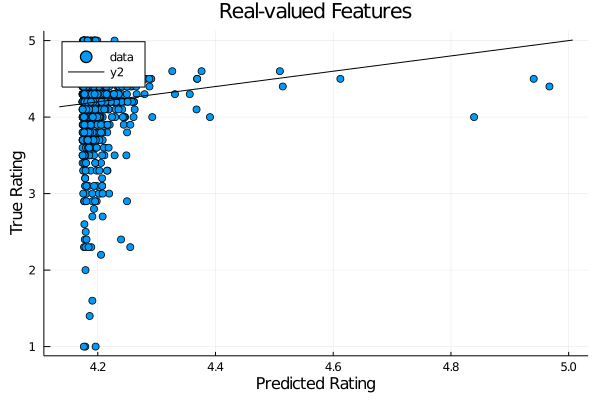

In [262]:
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued Features")

# (C) One-Hot Encoding

In [263]:
# Create one hot encoding for category-type columns 

cat_labels = [
    :Category,
    :Type,
    :ContentRating
]

#Sets of all categories in a particular column
cats_sets = [unique(train_x[:, label]) for label in cat_labels]

3-element Array{Array{String,1},1}:
 ["PHOTOGRAPHY", "TRAVEL_AND_LOCAL", "TOOLS", "PRODUCTIVITY", "FAMILY", "SHOPPING", "EVENTS", "BUSINESS", "MEDICAL", "PERSONALIZATION"  …  "HOUSE_AND_HOME", "HEALTH_AND_FITNESS", "WEATHER", "COMICS", "ENTERTAINMENT", "FOOD_AND_DRINK", "PARENTING", "AUTO_AND_VEHICLES", "ART_AND_DESIGN", "BEAUTY"]
 ["Free", "Paid", "NaN"]
 ["Everyone", "Everyone 10+", "Mature 17+", "Teen", "Adults only 18+", "Unrated"]

In [264]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    n = size(column,1) 
    d = size(cats,1) 
    result = zeros(n, d)
    for i = 1:n 
        for j=1:d
            if column[i] == cats[j] 
                result[i, j] = 1
            end 
        end
    end
    return result
end

onehot

In [265]:
category_onehot = onehot(train_x[:, :Category], cats_sets[1])

8672×33 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.

In [266]:
type_onehot = onehot(train_x[:, :Type], cats_sets[2])

8672×3 Array{Float64,2}:
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 ⋮         
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0
 1.0  0.0  0.0

In [267]:
content_rating_onehot = onehot(train_x[:, :ContentRating], cats_sets[3])

8672×6 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0

In [268]:
train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...) 

2168×42 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.

In [269]:
train_vals = hcat(train_cat_vals, train_vals_real)
test_vals = hcat(test_cat_vals, test_vals_real)

w = train_vals \ train_y 

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
        
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued + One-hot Features")
png("OneHot")

Train MSE	0.21988388294952754
Test MSE 	0.23181124944503895


# (D) Many-Hot Encoding

In [270]:
print(train_x[1:100, :Genres])

["Photography", "Travel & Local", "Tools", "Productivity", "Puzzle", "Shopping", "Events", "Productivity", "Tools", "Travel & Local", "Tools", "Tools", "Business", "Education", "Medical", "Entertainment", "Personalization", "Dating", "Communication", "Casual", "Dating", "Medical", "News & Magazines", "Medical", "Lifestyle", "Medical", "Racing", "Tools", "Video Players & Editors", "Education", "Arcade", "Medical", "Arcade", "Personalization", "Tools", "Dating", "Puzzle", "Social", "Business", "Personalization", "Travel & Local", "Strategy", "Strategy;Creativity", "Communication", "Business", "Entertainment", "News & Magazines", "Entertainment", "Tools", "Communication", "Libraries & Demo", "Medical", "News & Magazines", "Personalization", "Finance", "Books & Reference", "Productivity", "News & Magazines", "Puzzle", "Social", "Sports", "Medical", "Board", "Puzzle", "Sports", "Photography", "Entertainment;Pretend Play", "Maps & Navigation", "Finance", "Personalization", "Action", "Action"

In [271]:
split_genres(x) = split(x, ";")
example_genres = split_genres(train_x[4, :Genres])

1-element Array{SubString{String},1}:
 "Productivity"

In [272]:
genres_train = split_genres.(train_x[:, :Genres])
genres_test = split_genres.(test_x[:, :Genres])

2168-element Array{Array{SubString{String},1},1}:
 ["Role Playing"]
 ["Photography"]
 ["Racing"]
 ["Photography"]
 ["News & Magazines"]
 ["Communication"]
 ["Medical"]
 ["Dating"]
 ["Action"]
 ["Weather"]
 ["Tools"]
 ["Video Players & Editors"]
 ["Productivity"]
 ⋮
 ["Productivity"]
 ["Shopping"]
 ["Entertainment"]
 ["Finance"]
 ["Action"]
 ["Beauty"]
 ["Business"]
 ["Tools"]
 ["Weather"]
 ["Photography"]
 ["Entertainment"]
 ["Simulation"]

In [273]:
genre_types = unique(vcat(genres_train...))

53-element Array{SubString{String},1}:
 "Photography"
 "Travel & Local"
 "Tools"
 "Productivity"
 "Puzzle"
 "Shopping"
 "Events"
 "Business"
 "Education"
 "Medical"
 "Entertainment"
 "Personalization"
 "Dating"
 ⋮
 "Adventure"
 "Educational"
 "Parenting"
 "Auto & Vehicles"
 "Art & Design"
 "Card"
 "Beauty"
 "Music & Video"
 "Word"
 "Casino"
 "Music"
 "Music & Audio"

In [274]:
"Computes a manyhot vector for every entry in an array of arrays given a set of categories cats"
function manyhot(column, cats=unique(col))
    n = size(column, 1)
    d = size(cats, 1)
    result = zeros(n, d)
    
    for i = 1:n
        set_of_descriptions = column[i]
        for j = 1:d 
            if cats[j] in set_of_descriptions
                result[i, j] = 1 
            end
        end
    end 
    result
end

manyhot

In [275]:
genre_vals_train = manyhot(genres_train, genre_types)
genre_vals_test = manyhot(genres_test, genre_types)

two = 0 
for i=1:size(genre_vals_train, 1)
    total = sum(genre_vals_train[i, :])
    if total > 1
        two += 1
    end
end
println(two)
println(size(genre_vals_train, 1) - two)
println((size(genre_vals_train, 1) - two)/(two + size(genre_vals_train, 1)))

362
8310
0.9198583130396281


Train MSE	0.21772386332567517
Test MSE 	0.23014746609845307


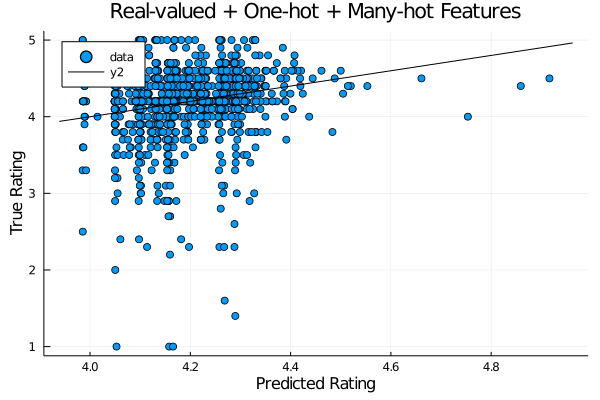

In [276]:
train_vals = hcat(genre_vals_train, train_vals)
test_vals = hcat(genre_vals_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "Real-valued + One-hot + Many-hot Features")

# (E) Data Exploration

### Ratings

In [277]:
println(mean(apps[:, :Rating]))
println(minimum(apps[:, :Rating]))
println(maximum(apps[:, :Rating]))
median(apps[:, :Rating])

4.192878228782288
1.0
5.0


4.2

In [278]:
@df apps density(:Rating, xlabel="App Rating", ylabel="Frequency", legend=false)
png("RatingDensity")

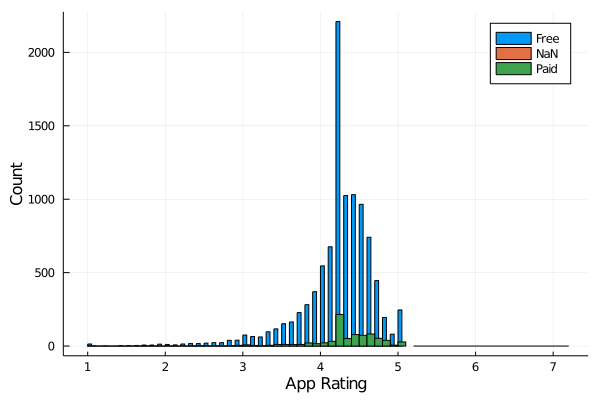

In [279]:
@df apps histogram(:Rating, group=:Type, xlabel="App Rating", ylabel="Count")

### Category

In [280]:
category_count = [] 
for idx=1:size(category_onehot,2)
    push!(category_count, sum(category_onehot[:, idx]))
end 
print(category_count)

Any[275.0, 215.0, 680.0, 339.0, 1561.0, 202.0, 54.0, 373.0, 374.0, 314.0, 186.0, 303.0, 221.0, 300.0, 927.0, 145.0, 243.0, 69.0, 295.0, 181.0, 303.0, 103.0, 134.0, 72.0, 264.0, 57.0, 52.0, 120.0, 96.0, 53.0, 70.0, 50.0, 41.0]

In [281]:
bar(category_count, xticks = (1:33, cats_sets[1]), xrotation=70, margin=10mm, legend=false, xlabel="Categories", ylabel="Count")
plot!(size=(700,600))
png("CategoryCount")


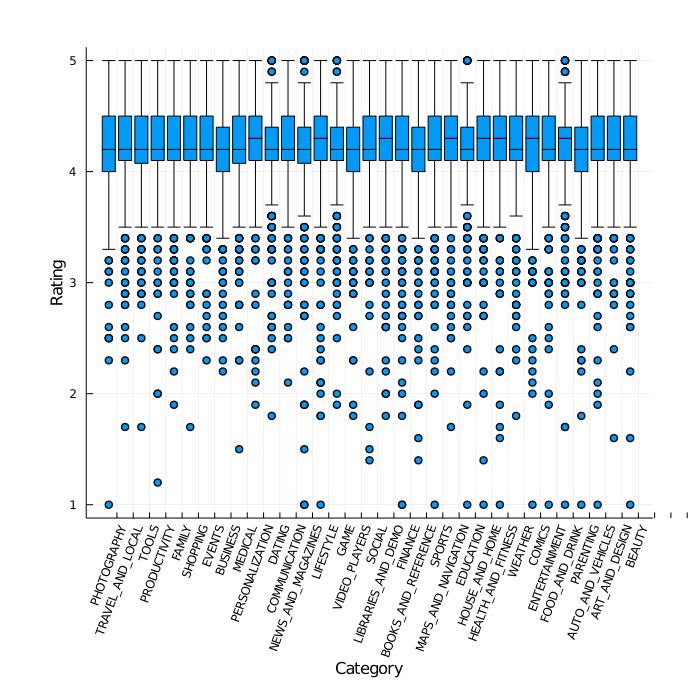

In [282]:
@df apps boxplot(cats_sets[1], :Rating, legend=false, xrotation=70, margin=10mm, xticks = (1:53, cats_sets[1]), 
    xlabel="Category", ylabel="Rating")
plot!(size=(700,700))

### Reviews

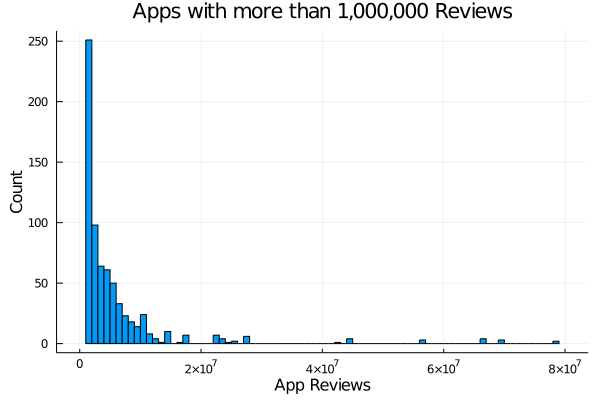

In [283]:
reviews_fl = transform(apps, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews)
reviews_float = filter(row -> (row.Reviews > 1000000), reviews_fl); 
@df reviews_float histogram(:Reviews, xlabel="App Reviews", ylabel="Count", title="Apps with more than 1,000,000 Reviews", legend=false)

In [284]:
println(mean(reviews_fl[:, :Reviews]))
println(minimum(reviews_fl[:, :Reviews]))
println(maximum(reviews_fl[:, :Reviews]))
median(reviews_fl[:, :Reviews])

444152.89603321033
0.0
7.8158306e7


2094.0

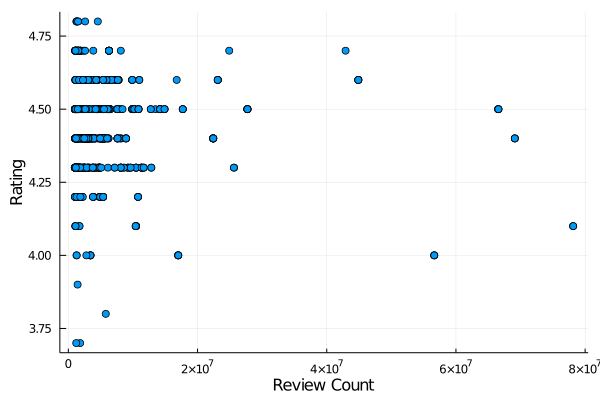

In [285]:
@df reviews_float scatter(:Reviews, :Rating, xlabel="Review Count", ylabel="Rating", legend=false)

### Size

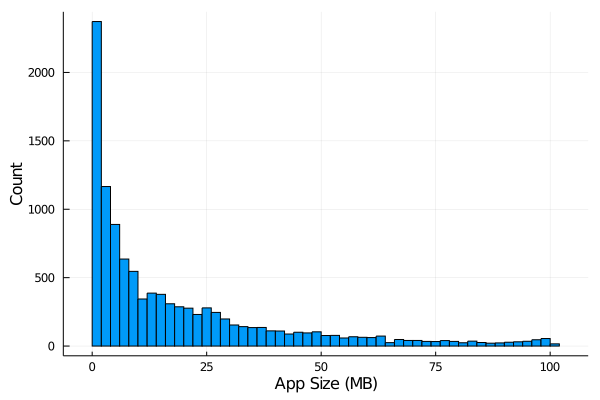

In [286]:
size_float = transform(apps, :Size => ByRow(x -> string_to_float(x)) => :Size)
@df size_float histogram(:Size, xlabel="App Size (MB)", ylabel="Count", legend=false)

In [287]:
println(mean(size_float[:, :Size]))
println(minimum(size_float[:, :Size]))
println(maximum(size_float[:, :Size]))
median(size_float[:, :Size])

18.152112546125462
0.0
100.0


9.2

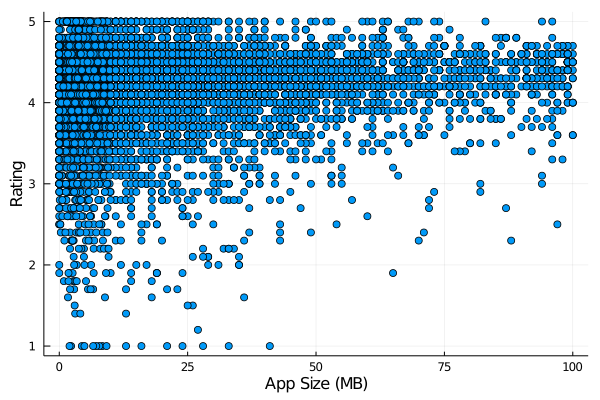

In [288]:
@df size_float scatter(:Size, :Rating, xlabel="App Size (MB)", ylabel="Rating", legend=false)

### Type and Installs

In [289]:
type_count = [] 
for idx=1:size(type_onehot,2)
    push!(type_count, sum(type_onehot[:, idx]))
end 
print(type_count)
646/(8025.0+646)


Any[8030.0, 641.0, 1.0]

0.07450121093299504

In [290]:
8025/(8025.0+646)

0.925498789067005

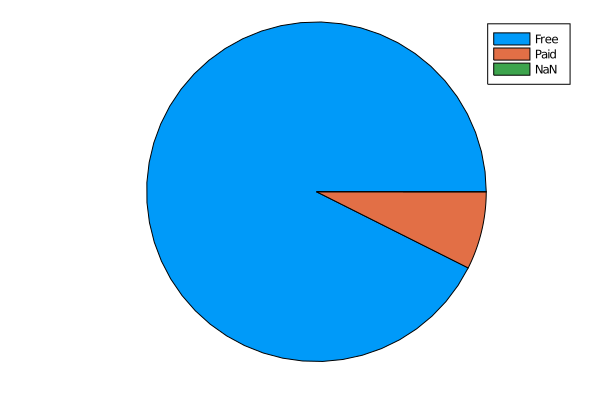

In [291]:
pie(cats_sets[2], type_count)

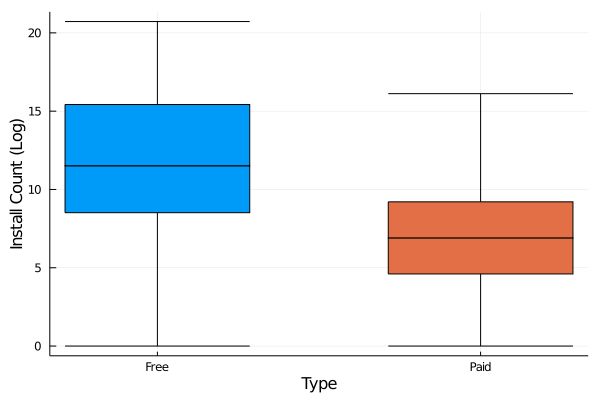

In [292]:
installs_fl = transform(apps, :Installs => ByRow(x -> string_to_float(x)) => :Installs)
installs_float = filter(row -> !(row.Installs in [0]), installs_fl); # log(0) is undefined. 
installs_log = transform(installs_float, :Installs => ByRow(x -> log(x)) => :Installs)
@df installs_log boxplot(:Type, :Installs, group=:Type, legend=false, xlabel="Type", ylabel="Install Count (Log)")

1.5464338882564576e7
0.0
1.0e9


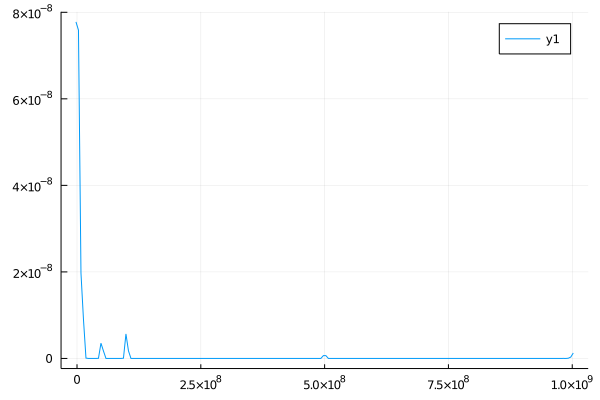

In [293]:
println(mean(installs_fl[:, :Installs]))
println(minimum(installs_fl[:, :Installs]))
println(maximum(installs_fl[:, :Installs]))
median(installs_fl[:, :Installs])

@df installs_fl density(:Installs)

### Price

In [310]:
for i=1:size(apps, 1)
    
    if apps[i, :Type] == "Free"
        if apps[i, :Price] != 0
            println(apps[i, :Price])
        end
    end
    
    if apps[i, :Price] == 0
        if apps[i, :Type] != "Free"
            println(apps[i, :Type])
        end
    end
end

# paid_apps = filter(row -> !(row.Type in ["Free"]), apps);

# non_zero = filter(row -> !(row.Price in [0]), apps)

# println("Count of paid apps: ", size(paid_apps))
# println("Count of paid apps: ", size(non_zero))

# price_float = Float64[]
# for i=1:size(paid_apps, 1)
#     price = paid_apps[i, :Price]
#     push!(price_float, price)
# end

NaN


In [304]:
println(minimum(paid_apps[:, :Price]))
println(maximum(paid_apps[:, :Price]))
println(mean(paid_apps[:, :Price]))

0.0
400.0
13.903458177278404


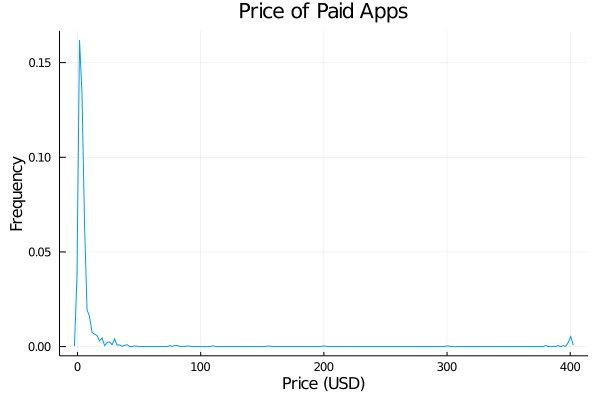

In [300]:
density(price_float, label=false, title="Price of Paid Apps", xlabel="Price (USD)", ylabel="Frequency")

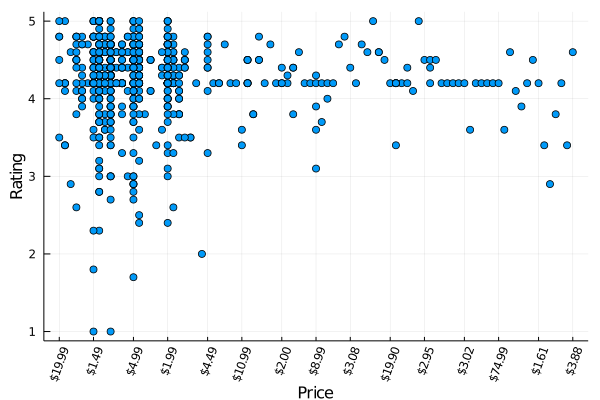

In [52]:
scatter(paid_apps[:, :Price], paid_apps[:, :Rating], xlabel="Price", ylabel="Rating", legend=false, xrotation=70)

### Content Rating

In [53]:
content_count = [] 
for idx=1:size(content_rating_onehot,2)
    push!(content_count, sum(content_rating_onehot[:, idx]))
end 

println(sum(content_count))
print(content_count./sum(content_count))

8671.0
[0.8046361434667282, 0.11082920078422327, 0.0390958366970361, 0.044977511244377814, 0.0002306539038173221, 0.0002306539038173221]

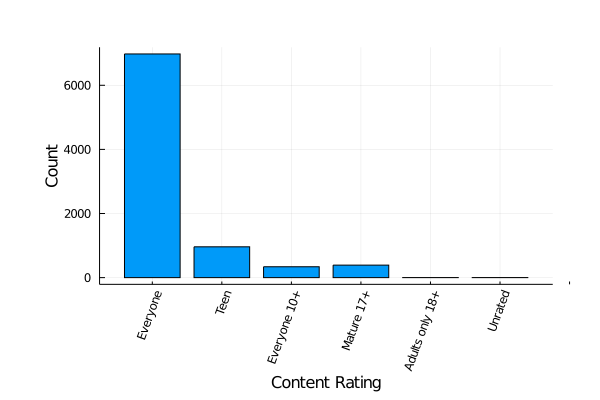

In [54]:
bar(content_count, xticks = (1:33, cats_sets[3]), xrotation=70, margin=10mm, legend=false, xlabel="Content Rating", ylabel="Count")
# plot!(size=(700,600))

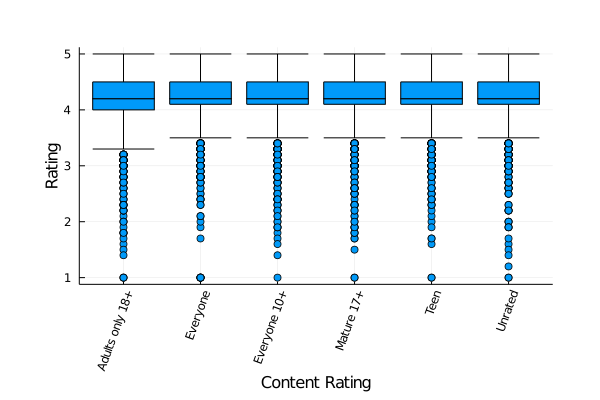

In [55]:
@df apps boxplot(cats_sets[3], :Rating, legend=false, xrotation=70, margin=10mm, 
    xlabel="Content Rating", ylabel="Rating")
# plot!(size=(700,700))

In [56]:
# Correlation between columns? Check for built in function. 
real_vals = transform(size_float, :Installs => ByRow(x -> string_to_float(x)) => :Installs);
real_vals = transform(real_vals, :Reviews => ByRow(x -> string_to_float(x)) => :Reviews);
real_vals = transform(real_vals, :Price => ByRow(x -> replace(x, "\$" => "")) => :Price)
real_vals = transform(real_vals, :Price => ByRow(x -> string_to_float(x)) => :Price);
real_vals = transform(real_vals, :LastUpdated => ByRow(x -> Dates.Date(x, "U d, y")) => :LastUpdated);
real_vals = transform(real_vals, :LastUpdated => ByRow(x -> Dates.datetime2rata(x)) => :LastUpdated);

In [57]:
@df real_vals corrplot([:Rating :Size :Installs :Reviews :Price :LastUpdated], grid=false);

In [58]:
correlation = @df real_vals cor([:Rating :Reviews :Size :Installs :Price :LastUpdated])

6×6 Array{Float64,2}:
  1.0         0.067662     0.0436581    0.0507947   -0.0201273    0.133047
  0.067662    1.0          0.0654481    0.643121    -0.00966818   0.0852966
  0.0436581   0.0654481    1.0         -0.00347054  -0.0134584    0.144876
  0.0507947   0.643121    -0.00347054   1.0         -0.0116906    0.100924
 -0.0201273  -0.00966818  -0.0134584   -0.0116906    1.0         -0.00686084
  0.133047    0.0852966    0.144876     0.100924    -0.00686084   1.0

In [59]:
correlation_labels = correlation
for i=1:6
    for j=1:6
        correlation_labels[i, j] = round(correlation[i, j], digits=4)
    end
end

In [60]:
theme(:sand)
labels = ["Rating", "Reviews", "Size", "Installs", "Price", "LastUpdated"]
heatmap(labels, labels, correlation, yflip=true)
annotate!(vec(tuple.((1:length(labels))'.-0.5, (1:length(labels)).-0.5, string.(correlation_labels), 10)))
png("CorrelationPlot")
# annotate!(correlation)

# (F) Date Data

### Last Updated Column

In [61]:
# Convert lastUpdated column from string to type date
apps_date = Dates.Date.(apps[:, :LastUpdated], "U d, y");

In [62]:
# Convert type date to numerical value (Int64)
apps_date_real = Dates.datetime2rata.(apps_date);

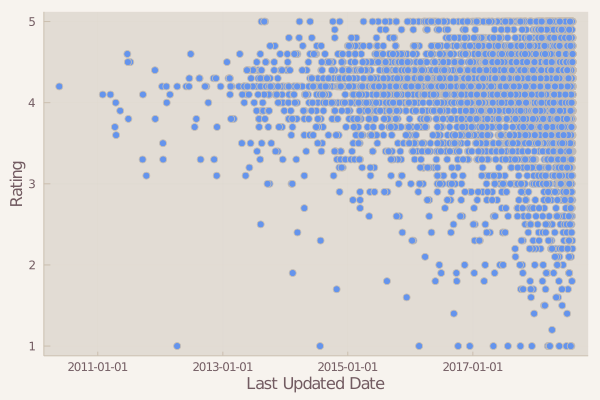

In [63]:
# Plot LastUpdated vs Rating
scatter(apps_date, apps[:, :Rating], xlabel="Last Updated Date", ylabel="Rating", legend=false)

In [64]:
println(minimum(apps_date))
println(maximum(apps_date))
print(Dates.rata2datetime(median(apps_date_real)))

2010-05-21
2018-08-08
2018-05-24T00:00:00

In [65]:
# Convert LastUpdated column for training and testing data to numerical value 
date_train = Dates.Date.(train_x[:, :LastUpdated], "U d, y");
date_test = Dates.Date.(test_x[:, :LastUpdated], "U d, y");

In [66]:
# Next convert type date to numerical value (Int64)
lastUpdated_train = Dates.datetime2rata.(date_train);
lastUpdated_test = Dates.datetime2rata.(date_test); 

Train MSE	0.2139510399518327
Test MSE 	0.22456568523545706


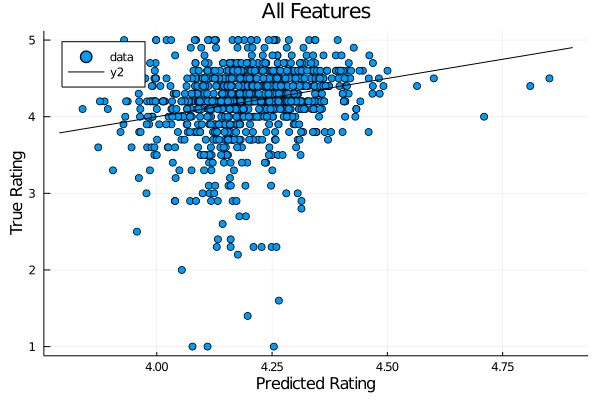

In [67]:
train_vals = hcat(lastUpdated_train, train_vals)
test_vals = hcat(lastUpdated_test, test_vals)

w = train_vals \ train_y

train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)
    
println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "All Features")

### User Reviews

In [68]:
reviews = CSV.read("googleplaystore_user_reviews.csv", pool=false)
names!(reviews, Symbol.(replace.(string.(names(reviews)), Ref(r"\s"=>"")))) #remove whitespace from column names
feature_names = names(reviews)
for i in 1:5
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(apps[!, i])))
end

1	App			String
2	Translated_Review			String
3	Sentiment			Float64
4	Sentiment_Polarity			String
5	Sentiment_Subjectivity			String


In [69]:
reviews

64295×5 DataFrame. Omitted printing of 4 columns
│ Row   │ App                         │
│       │ String                      │
├───────┼─────────────────────────────┤
│ 1     │ 10 Best Foods for You       │
│ 2     │ 10 Best Foods for You       │
│ 3     │ 10 Best Foods for You       │
│ 4     │ 10 Best Foods for You       │
│ 5     │ 10 Best Foods for You       │
│ 6     │ 10 Best Foods for You       │
│ 7     │ 10 Best Foods for You       │
│ 8     │ 10 Best Foods for You       │
│ 9     │ 10 Best Foods for You       │
│ 10    │ 10 Best Foods for You       │
⋮
│ 64285 │ Houzz Interior Design Ideas │
│ 64286 │ Houzz Interior Design Ideas │
│ 64287 │ Houzz Interior Design Ideas │
│ 64288 │ Houzz Interior Design Ideas │
│ 64289 │ Houzz Interior Design Ideas │
│ 64290 │ Houzz Interior Design Ideas │
│ 64291 │ Houzz Interior Design Ideas │
│ 64292 │ Houzz Interior Design Ideas │
│ 64293 │ Houzz Interior Design Ideas │
│ 64294 │ Houzz Interior Design Ideas │
│ 64295 │ Houzz Interior Design Ideas │

In [70]:
# reviews = filter(row -> !(row.Translated_Review ), reviews)

In [71]:
print("Number of apps with reviews: ", length(unique(reviews[:, :App])))

Number of apps with reviews: 1074

In [72]:
unique_apps = unique(apps[:, :App]);

In [73]:
unique_revs = unique(reviews[:, :App]);

In [74]:
match_reviews = filter(row -> (row.App in unique_apps), reviews)
print(length(unique(match_reviews[:, :App])))

1020

# (G) Feature Modeling

Let's compare predict rating with each feature individually to see which has the lowest error and explore that feature more closely.

### Category

In [75]:
train_vals_cat = hcat(onehot(train_x[:, :Category], cats_sets[1]), ones(ntrain, 1))
test_vals_cat = hcat(onehot(test_x[:, :Category], cats_sets[1]), ones(ntest, 1))

w = train_vals_cat \ train_y

train_pred_cat = [sum(w.*train_vals_cat[i, :]) for i=1:size(train_vals_cat, 1)] 
test_pred_cat = [sum(w.*test_vals_cat[i, :]) for i=1:size(test_vals_cat, 1)] 

train_MSE_cat = MSE(train_y, train_pred_cat)
test_MSE_cat = MSE(test_y, test_pred_cat)
    
println("Train MSE\t", train_MSE_cat)
println("Test MSE \t", test_MSE_cat)

Train MSE	0.22152556651167396
Test MSE 	0.23138910669787674


### Reviews

In [76]:
train_vals_rev = hcat(train_vals_real[:, 1], ones(ntrain, 1))
test_vals_rev = hcat(test_vals_real[:, 1], ones(ntest, 1))

w = train_vals_rev \ train_y

train_pred_rev = [sum(w.*train_vals_rev[i, :]) for i=1:size(train_vals_rev, 1)] 
test_pred_rev = [sum(w.*test_vals_rev[i, :]) for i=1:size(test_vals_rev, 1)] 

train_MSE_rev = MSE(train_y, train_pred_rev)
test_MSE_rev = MSE(test_y, test_pred_rev)
    
println("Train MSE\t", train_MSE_rev)
println("Test MSE \t", test_MSE_rev)

Train MSE	0.22708441250060776
Test MSE 	0.23336676971929643


### Size

In [77]:
train_vals_size = hcat(train_vals_real[:, 2], ones(ntrain, 1))
test_vals_size = hcat(test_vals_real[:, 2], ones(ntest, 1))

w = train_vals_size \ train_y

train_pred_size = [sum(w.*train_vals_size[i, :]) for i=1:size(train_vals_size, 1)] 
test_pred_size = [sum(w.*test_vals_size[i, :]) for i=1:size(test_vals_size, 1)] 

train_MSE_size = MSE(train_y, train_pred_size)
test_MSE_size = MSE(test_y, test_pred_size)
    
println("Train MSE\t", train_MSE_size)
println("Test MSE \t", test_MSE_size)

Train MSE	0.22771117483250775
Test MSE 	0.23386631543892958


### Installs

In [78]:
train_vals_installs = hcat(train_vals_real[:, 3], ones(ntrain, 1))
test_vals_installs = hcat(test_vals_real[:, 3], ones(ntest, 1))

w = train_vals_installs \ train_y

train_pred_installs = [sum(w.*train_vals_installs[i, :]) for i=1:size(train_vals_installs, 1)] 
test_pred_installs = [sum(w.*test_vals_installs[i, :]) for i=1:size(test_vals_installs, 1)] 

train_MSE_installs = MSE(train_y, train_pred_installs)
test_MSE_installs = MSE(test_y, test_pred_installs)
    
println("Train MSE\t", train_MSE_installs)
println("Test MSE \t", test_MSE_installs)

Train MSE	0.2276716110440423
Test MSE 	0.23323257166779615


### Type

In [79]:
train_vals_type = hcat(onehot(train_x[:, :Type], cats_sets[2]), ones(ntrain, 1))
test_vals_type = hcat(onehot(test_x[:, :Type], cats_sets[2]), ones(ntest, 1))

w = train_vals_type \ train_y

train_pred_type = [sum(w.*train_vals_type[i, :]) for i=1:size(train_vals_type, 1)] 
test_pred_type = [sum(w.*test_vals_type[i, :]) for i=1:size(test_vals_type, 1)] 

train_MSE_type = MSE(train_y, train_pred_type)
test_MSE_type = MSE(test_y, test_pred_type)
    
println("Train MSE\t", train_MSE_type)
println("Test MSE \t", test_MSE_type)

Train MSE	0.22797803045735202
Test MSE 	0.23411193225656488


### Price

In [80]:
# train_vals = hcat(onehot(train_x[:, :Category], cats_sets[1]), ones(ntrain, 1))
# test_vals = hcat(onehot(test_x[:, :Category], cats_sets[1]), ones(ntest, 1))

# w = train_vals \ train_y

# train_pred = [sum(w.*train_vals[i, :]) for i=1:size(train_vals, 1)] 
# test_pred = [sum(w.*test_vals[i, :]) for i=1:size(test_vals, 1)] 

# train_MSE = MSE(train_y, train_pred)
# test_MSE = MSE(test_y, test_pred)
    
# println("Train MSE\t", train_MSE)
# println("Test MSE \t", test_MSE)

### Content Rating

In [81]:
train_vals_cr = hcat(onehot(train_x[:, :ContentRating], cats_sets[3]), ones(ntrain, 1))
test_vals_cr = hcat(onehot(test_x[:, :ContentRating], cats_sets[3]), ones(ntest, 1))

w = train_vals_cr \ train_y

train_pred_cr = [sum(w.*train_vals_cr[i, :]) for i=1:size(train_vals_cr, 1)] 
test_pred_cr = [sum(w.*test_vals_cr[i, :]) for i=1:size(test_vals_cr, 1)] 

train_MSE_cr = MSE(train_y, train_pred_cr)
test_MSE_cr = MSE(test_y, test_pred_cr)
    
println("Train MSE\t", train_MSE_cr)
println("Test MSE \t", test_MSE_cr)

Train MSE	0.22756986358885875
Test MSE 	0.2341877374969819


### Genres

In [82]:
train_vals_genre = hcat(genre_vals_train, ones(ntrain, 1))
test_vals_genre = hcat(genre_vals_test, ones(ntest, 1))

w = train_vals_genre \ train_y

train_pred_genre = [sum(w.*train_vals_genre[i, :]) for i=1:size(train_vals_genre, 1)] 
test_pred_genre = [sum(w.*test_vals_genre[i, :]) for i=1:size(test_vals_genre, 1)] 

train_MSE_genre = MSE(train_y, train_pred_genre)
test_MSE_genre = MSE(test_y, test_pred_genre)
    
println("Train MSE\t", train_MSE_genre)
println("Test MSE \t", test_MSE_genre)

Train MSE	0.22018072178116732
Test MSE 	0.23007731811108137


### Last Updated

Train MSE	0.2243234092311271
Test MSE 	0.22930561959754162


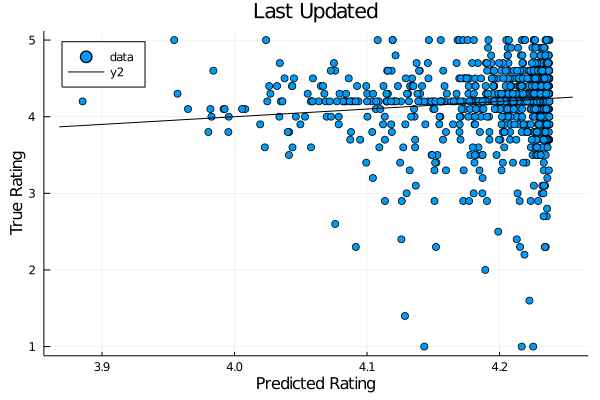

In [83]:
train_vals_update = hcat(lastUpdated_train, ones(ntrain, 1))
test_vals_update = hcat(lastUpdated_test, ones(ntest, 1))

w = train_vals_update \ train_y

train_pred_update = [sum(w.*train_vals_update[i, :]) for i=1:size(train_vals_update, 1)] 
test_pred_update = [sum(w.*test_vals_update[i, :]) for i=1:size(test_vals_update, 1)] 

train_MSE_update = MSE(train_y, train_pred_update)
test_MSE_update = MSE(test_y, test_pred_update)
    
println("Train MSE\t", train_MSE_update)
println("Test MSE \t", test_MSE_update)

plot_pred_true(test_pred_update, test_y, "Last Updated")

# (H) Regularized Linear Models

### L1 Loss

Train MSE	0.22802201613382023
Test MSE 	0.23391231452920377


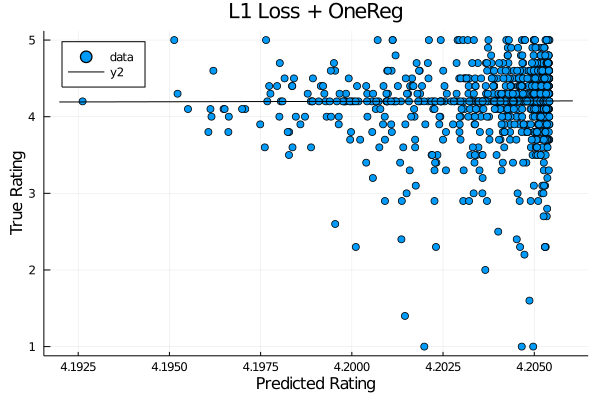

In [84]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg = λ * OneReg()
w_l1 = proxgrad(loss, reg, train_vals_update, train_y, maxiters=100)

train_pred = train_vals_update*w_l1
test_pred = test_vals_update*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + OneReg")

In [85]:
println("Min predicted rating: ", minimum(test_pred))
println("Max predicted rating: ", maximum(test_pred))

Min predicted rating: 4.1901900092941275
Max predicted rating: 4.205415754031625


**Note:** Our predicted ratings are in the range 0-9, we need to limit this to 1-5. Let's try other regularizers to see if that helps.

Train MSE	17.112639724770997
Test MSE 	17.003384955438772


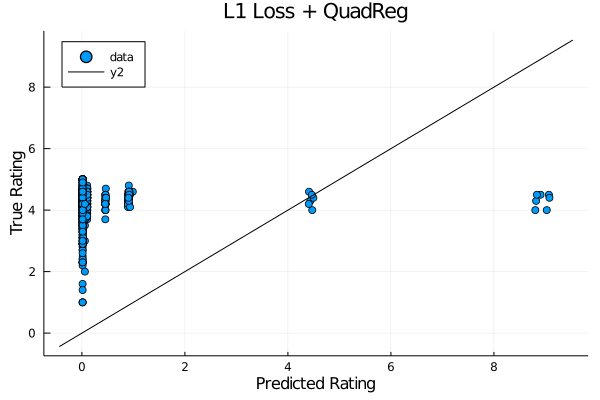

In [86]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg =  λ * QuadReg()
w_l1 = proxgrad(loss, reg, train_vals, train_y, maxiters=100) 

train_pred = train_vals*w_l1
test_pred = test_vals*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + QuadReg")

**Note:** Let's experiment using features individually and some combinations.

In [87]:
features_train = [train_vals_cat, train_vals_rev, train_vals_size, train_vals_installs, train_vals_type, train_vals_cr, 
    train_vals_genre, train_vals_update]

features_test = [test_vals_cat, test_vals_rev, test_vals_size, test_vals_installs, test_vals_type, test_vals_cr, 
    test_vals_genre, test_vals_update]

features = ["Category", "Reviews", "Size", "Installs", "Type", "ContentRating", "Genre", "LastUpdate"]

for i=1:length(features_train)
    
    println(features[i])
    
    loss = 1/ntrain * L1Loss()
    λ = 0.1
    reg = λ * OneReg()
    w_l1 = proxgrad(loss, reg, features_train[i], train_y, maxiters=100)

    train_pred = features_train[i]*w_l1
    test_pred = features_test[i]*w_l1

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)
    
    println("Min predicted rating: ", minimum(test_pred))
    println("Max predicted rating: ", maximum(test_pred))

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)
    print("\n")
       
end


Category
Train MSE	0.23023474811232458
Test MSE 	0.23719883799918642
Min predicted rating: 4.200000000000001
Max predicted rating: 4.303785235427193

Reviews
Train MSE	18.24649747336217
Test MSE 	19.391899692291272
Min predicted rating: 6.851958776894459e-12
Max predicted rating: 39.93511737928209

Size
Train MSE	8.425865398147023
Test MSE 	8.48064586969627
Min predicted rating: 0.4790681582285802
Max predicted rating: 9.325222004382379

Installs
Train MSE	17.233246495269707
Test MSE 	17.118516753254838
Min predicted rating: 2.5307123465925117e-14
Max predicted rating: 8.80000000003208

Type
Train MSE	0.4255703569961422
Test MSE 	0.4133736511827945
Min predicted rating: 2.634285119958976
Max predicted rating: 4.210425556452563

ContentRating
Train MSE	0.44676792700627865
Test MSE 	0.4499424993275537
Min predicted rating: 3.09958000266695
Max predicted rating: 4.200177225089397

Genre
Train MSE	0.2282620228347365
Test MSE 	0.23400369003690044
Min predicted rating: 4.200000000000001
Max 

Min predicted rating: 4.1889529389779225
Max predicted rating: 5.722328554818288
Train MSE	0.2277692857227316
Test MSE 	0.23619236537570587


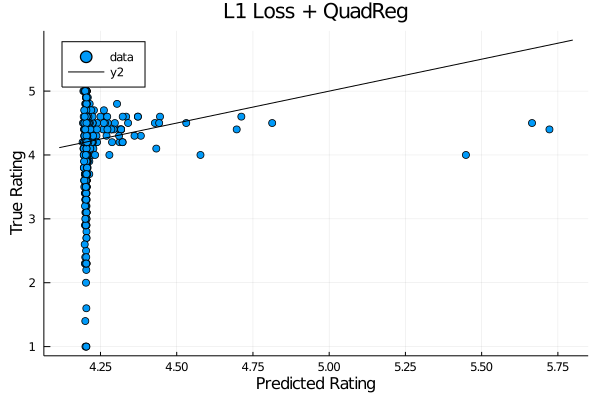

In [88]:
loss = 1/ntrain * L1Loss()
λ = 0.1
reg =  λ * QuadReg()

train_vals_rev_update = hcat(train_vals_rev, train_vals_update)
test_vals_rev_update = hcat(test_vals_rev, test_vals_update)

w_l1 = proxgrad(loss, reg, train_vals_rev_update, train_y, maxiters=100) 

train_pred = train_vals_rev_update*w_l1
test_pred = test_vals_rev_update*w_l1

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Min predicted rating: ", minimum(test_pred))
println("Max predicted rating: ", maximum(test_pred))

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

plot_pred_true(test_pred, test_y, "L1 Loss + QuadReg")

# (I) Other Sklearn Models

In [105]:
Pkg.add("ScikitLearn")
using ScikitLearn
@sk_import linear_model: (Ridge, Lasso, ElasticNet)
@sk_import metrics: mean_absolute_error
@sk_import svm: SVR
@sk_import ensemble: RandomForestRegressor
@sk_import neural_network: MLPRegressor
@sk_import tree: (plot_tree, DecisionTreeRegressor)
@sk_import feature_selection: (SelectFromModel, VarianceThreshold)

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


PyObject <class 'sklearn.feature_selection._variance_threshold.VarianceThreshold'>

In [90]:
ridge = Ridge()
ridge.fit(train_vals, train_y)

train_pred = ridge.predict(train_vals);
test_pred = ridge.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
  
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Ridge Regression")

Train MSE	0.2139606526992846
Test MSE 	0.22336169396664612

Train MAE	0.30823001290417706
Test MAE 	0.31161494065260703


In [91]:
lasso = Lasso()
lasso.fit(train_vals, train_y)

train_pred = lasso.predict(train_vals);
test_pred = lasso.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Lasso")

Train MSE	0.22349990124693772
Test MSE 	0.22907296014266043

Train MAE	0.31015597918873367
Test MAE 	0.31074043228908677


Train MSE	0.2234951324114063
Test MSE 	0.22904527791170073

Train MAE	0.3102389485798811
Test MAE 	0.31079951866736016


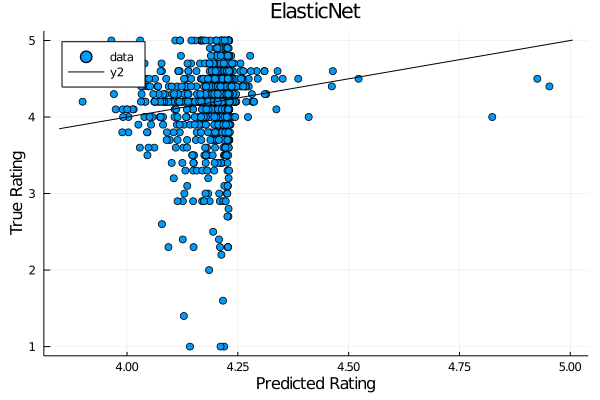

In [92]:
en = ElasticNet()
en.fit(train_vals, train_y)

train_pred = en.predict(train_vals);
test_pred = en.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "ElasticNet")

In [93]:
kernels = ["rbf"]

for i=1:length(kernels)

    println("Type of kernel: ", kernels[i])
    svrModel = SVR(kernel=kernels[i])
    svrModel.fit(train_vals, train_y)

    train_pred = svrModel.predict(train_vals);
    test_pred = svrModel.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

    train_MAE = mean_absolute_error(train_y, train_pred)
    test_MAE = mean_absolute_error(test_y, test_pred)

    print("\n")
    println("Train MAE\t", train_MAE)
    println("Test MAE \t", test_MAE)

    plot_pred_true(test_pred, test_y, "Support Vector Machine")
    
end

Type of kernel: rbf
Train MSE	0.23664839067213708
Test MSE 	0.2468861627505898

Train MAE	0.30957502900800893
Test MAE 	0.3190020460109613


In [94]:
dt = DecisionTreeRegressor()
dt.fit(train_vals, train_y)

train_pred = dt.predict(train_vals);
test_pred = dt.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Decision Tree")

Train MSE	5.189712835889741e-6
Test MSE 	0.3699261992619926

Train MAE	3.459808557284397e-5
Test MAE 	0.3630996309963102


In [95]:
for i=1:10
    
    println("Max depth: ", i)
    dt = DecisionTreeRegressor(max_depth=i, random_state=1)
    dt.fit(train_vals, train_y)

    train_pred = dt.predict(train_vals);
    test_pred = dt.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)
    print("\n")

end

Max depth: 1
Train MSE	0.21866763099597877
Test MSE 	0.22328238224772368

Max depth: 2
Train MSE	0.21485141231734312
Test MSE 	0.21919828802636285

Max depth: 3
Train MSE	0.21026568029354656
Test MSE 	0.21560673358151505

Max depth: 4
Train MSE	0.20563068577359853
Test MSE 	0.21567653402286413

Max depth: 5
Train MSE	0.20024852969419046
Test MSE 	0.21326143928320773

Max depth: 6
Train MSE	0.19285119110166454
Test MSE 	0.21424373090623808

Max depth: 7
Train MSE	0.18589105563781275
Test MSE 	0.2152642059745965

Max depth: 8
Train MSE	0.17758443945129804
Test MSE 	0.21422352313274007

Max depth: 9
Train MSE	0.16509880850423603
Test MSE 	0.22377231505292022

Max depth: 10
Train MSE	0.15081630484580427
Test MSE 	0.22629628479073174



In [96]:
dt = DecisionTreeRegressor(max_depth=5)
@time begin
dt.fit(train_vals, train_y)
end

train_pred = dt.predict(train_vals);
test_pred = dt.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Decision Tree Max-Depth=5")
# png("DecisionTree")
println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_vals))

  0.021537 seconds (17 allocations: 976 bytes)
Train MSE	0.20024852969419046
Test MSE 	0.2132614392832077

3.1916666666666664
4.7
6867432


In [97]:
print(dt.feature_importances_)

[0.03472569841121911, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024779946056496297, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01003193432725969, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0035213275743528885, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02340860532903439, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05133163672525154, 0.0, 0.0, 0.0, 0.0, 0.0008870047496902705, 0.0, 0.0, 0.0, 0.0, 0.005582907818452904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0010374149514537658, 0.0, 0.004588324148916951, 0.0, 0.0, 0.6043899665002811, 0.033297329708593816, 0.224719855149844, 0.0]

In [98]:
println(maximum(dt.feature_importances_))
println(minimum(dt.feature_importances_))
println(mean(dt.feature_importances_))

0.6043899665002811
0.0
0.010101010101010102


In [106]:
sfm = SelectFromModel(dt, threshold=0.05)
sfm.fit(train_vals, train_y)
train_transformed = sfm.transform(train_vals) 
test_transformed = sfm.transform(test_vals)

println("Shape of the dataset ", size(train_transformed))

@time begin
dt.fit(train_transformed, train_y)
end

train_pred = dt.predict(train_transformed);
test_pred = dt.predict(test_transformed);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Reduced Decision Tree Max-Depth=5")
# png("DecisionTreeTransformed")

println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_transformed))

Shape of the dataset (8671, 3)
  0.003781 seconds (17 allocations: 976 bytes)
Train MSE	0.2016350767432339
Test MSE 	0.21138125001292327

3.823591549295774
4.6047619047619035
208104


In [108]:
train_vals_update_rev = hcat(train_vals_update, train_vals_rev)
test_vals_update_rev = hcat(test_vals_update, test_vals_rev)

dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_vals_update_rev, train_y)

train_pred = dt.predict(train_vals_update_rev);
test_pred = dt.predict(test_vals_update_rev);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Decision Tree")

Train MSE	0.2101695872043635
Test MSE 	0.21747026330640606

Train MAE	0.3018340141407321
Test MAE 	0.30598839626771607


Train MSE	0.025922693297485894
Test MSE 	0.20241091071840406

Train MAE	0.10088914196747793
Test MAE 	0.28147543819188214


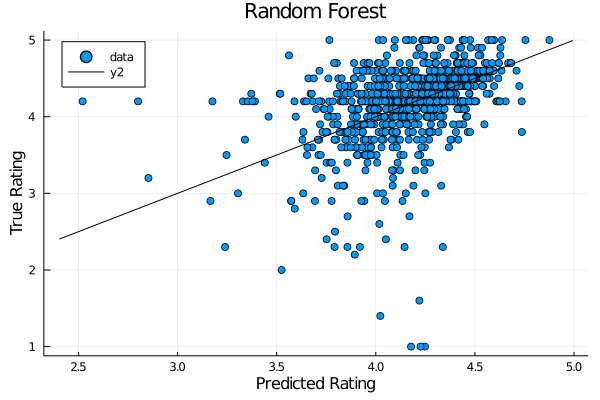

In [109]:
rf = RandomForestRegressor()
rf.fit(train_vals, train_y)

train_pred = rf.predict(train_vals);
test_pred = rf.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

train_MAE = mean_absolute_error(train_y, train_pred)
test_MAE = mean_absolute_error(test_y, test_pred)
    
print("\n")
println("Train MAE\t", train_MAE)
println("Test MAE \t", test_MAE)

plot_pred_true(test_pred, test_y, "Random Forest")

**Note:** Random Forest Regression has the lowest training error thus far, but there is overfitting occuring. Can we reduce the number of features? 

In [102]:
features_train = [train_vals_cat, train_vals_rev, train_vals_size, train_vals_installs, train_vals_type, train_vals_cr, 
    train_vals_genre, train_vals_update]

features_test = [test_vals_cat, test_vals_rev, test_vals_size, test_vals_installs, test_vals_type, test_vals_cr, 
    test_vals_genre, test_vals_update]

features = ["Category", "Reviews", "Size", "Installs", "Type", "ContentRating", "Genre", "LastUpdate"]

for i=1:length(features_train)
    
    println(features[i])
    
    rf = RandomForestRegressor()
    rf.fit(features_train[i], train_y)
    
    train_pred = rf.predict(features_train[i]);
    test_pred = rf.predict(features_test[i]);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)
    print("\n")
       
end


Category
Train MSE	0.2215378334482373
Test MSE 	0.23138988925726947

Reviews
Train MSE	0.14461492569962464
Test MSE 	0.25447459538997946

Size
Train MSE	0.2193374802521966
Test MSE 	0.23493450888670678

Installs
Train MSE	0.21791463770313121
Test MSE 	0.22107276855610528

Type
Train MSE	0.22791327465766284
Test MSE 	0.23376000320145704

ContentRating
Train MSE	0.22757108984016197
Test MSE 	0.23422090387518657

Genre
Train MSE	0.21944181204759902
Test MSE 	0.22960195812849885

LastUpdate
Train MSE	0.1837730248385679
Test MSE 	0.2608369480809724



**Note:** Overfitting still occurs even when reducing feature count. Let's try early stopping, i.e. changing the max depth, rather than reaching pure leaves.

In [110]:
for i=1:10
    
    println("Max depth: ", i)
    rf = RandomForestRegressor(max_depth=i, random_state=1)
    rf.fit(train_vals, train_y)

    train_pred = rf.predict(train_vals);
    test_pred = rf.predict(test_vals);

    train_MSE = MSE(train_y, train_pred)
    test_MSE = MSE(test_y, test_pred)

    println("Train MSE\t", train_MSE)
    println("Test MSE \t", test_MSE)

#     train_MAE = mean_absolute_error(train_y, train_pred)
#     test_MAE = mean_absolute_error(test_y, test_pred)
    
#     println("Train MAE\t", train_MAE)
#     println("Test MAE \t", test_MAE)

    print("\n")

#     plot_pred_true(test_pred, test_y, "Random Forest")
end

Max depth: 1
Train MSE	0.21764930986717854
Test MSE 	0.22248162569589552

Max depth: 2
Train MSE	0.21298255107310812
Test MSE 	0.21694213278459173

Max depth: 3
Train MSE	0.20732200910735724
Test MSE 	0.21241284540071598

Max depth: 4
Train MSE	0.2007906632937323
Test MSE 	0.20863574422776676

Max depth: 5
Train MSE	0.1940373259168298
Test MSE 	0.20550720264830832

Max depth: 6
Train MSE	0.1856381664686659
Test MSE 	0.20244133364555386

Max depth: 7
Train MSE	0.1752239752219714
Test MSE 	0.20035003792865197

Max depth: 8
Train MSE	0.16347772365713956
Test MSE 	0.19891792098042863

Max depth: 9
Train MSE	0.1514054913683832
Test MSE 	0.19823603545606475

Max depth: 10
Train MSE	0.1386324919857248
Test MSE 	0.19807367679431018



**Conclusion:** Max depth of 4 performs best

In [120]:
rf = RandomForestRegressor(max_depth=5, random_state=1)
rf.fit(train_vals, train_y)

train_pred = rf.predict(train_vals);
test_pred = rf.predict(test_vals);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

plot_pred_true(test_pred, test_y, "Random Forest Max Depth=5")
png("RandomForest")

In [113]:
println(maximum(rf.feature_importances_))
println(minimum(rf.feature_importances_))
println(mean(rf.feature_importances_))

0.5356000009132986
0.0
0.010101010101010102


In [114]:
print(rf.feature_importances_)

[0.06760905610261388, 0.0010053663089206887, 7.182884036760208e-5, 0.0012372791649119161, 0.0, 0.0004475369248996813, 0.0005418543795546513, 0.015502011514435568, 0.018696557288057643, 0.004130969887498029, 0.00023499905083647758, 0.0, 0.00022923900125988112, 0.0, 0.0011738637477131336, 0.0, 0.00724021629234677, 0.0004395504485939912, 0.0012918600873445454, 0.0014540755268573416, 0.0, 0.002292439608715476, 0.0006610510588097363, 0.002589666428677507, 0.0038679739487737356, 0.0, 0.0004328755716851496, 6.807316812531954e-5, 1.1615638597652834e-5, 0.003953763003898572, 0.0011714137999303095, 0.000478565773885282, 0.00021164436566031844, 0.001395312978332849, 0.0, 9.846926282598601e-5, 0.00046592326133620515, 0.0, 0.0, 0.0, 0.0001192710135878257, 0.00040086995487457377, 0.000200561902920183, 9.127462213321571e-6, 0.0011485532814433557, 0.0, 0.0, 0.0007702239754710572, 0.00012096367543342305, 0.00044247895630531716, 4.182792324876398e-5, 0.00565267310200778, 0.002485573865417101, 0.0, 0.001

In [118]:
sfm = SelectFromModel(rf, threshold=0.0005)
sfm.fit(train_vals, train_y)
train_transformed = sfm.transform(train_vals) 
test_transformed = sfm.transform(test_vals)

println("Shape of the dataset ", size(train_transformed))

@time begin
rf.fit(train_transformed, train_y)
end

train_pred = rf.predict(train_transformed);
test_pred = rf.predict(test_transformed);

train_MSE = MSE(train_y, train_pred)
test_MSE = MSE(test_y, test_pred)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)
print("\n")

plot_pred_true(test_pred, test_y, "Reduced Random Forest Max-Depth=5")
# png("DecisionTreeTransformed")

println(minimum(test_pred))
println(maximum(test_pred))
println(sizeof(train_transformed))

Shape of the dataset (8671, 48)
  0.941639 seconds (17 allocations: 976 bytes)
Train MSE	0.1940670088859627
Test MSE 	0.20551587830669268

3.7143284244380586
4.503314722789965
3329664
